# <b>背景</b>

目前妊娠期糖尿病（GDM）的诊断依靠糖耐量试验（OGTT），一种葡萄糖负荷试验，用以了解胰岛β细胞功能和机体对血糖的调节能力，是诊断糖尿病的确诊试验。诊断GDM的标准为空腹血糖≥5.1mmol/L，1小时≥10.0mmol/L，2小时大于等于8.5mmol/L。如果空腹血糖≥7.0mmol/L，或者2小时血糖大于≥11.1mmol/L，则诊断为糖尿病DM。

糖化血红蛋白（HbA1c）是判断糖尿病患者血糖控制良好与否非常重要的一个指标，可以反映患者近8-12周的血糖控制情况。糖化血红蛋白（HbA1c）在妊娠期没有明确的参考值范围，当HbA1c≥6.5%，则诊断为DM。对于诊断GDM则没有参考值。

# <b>任务</b>

通过统计手段了解OGTT和HbA1c检测结果的基本情况。

# <b>第一步 引包</b>

In [1]:
#引包：引入所需python包
import xlrd
import os
import re
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve,auc
import matplotlib as mpl
from matplotlib import pyplot as plt
from numpy import nan
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
import time

from scipy.stats import kstest
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# <b>第二步 获取数据源</b>
设置默认文件目录

读取csv文件

In [2]:
dir = r"./output/"
print(os.listdir(dir))

['clean_data.csv']


In [38]:
HbA1c_ref = pd.read_csv(dir+"clean_data.csv",index_col=0) #第一列为行索引
HbA1c_ref = HbA1c_ref.drop(columns = HbA1c_ref.columns[0]) #删除不需要的列
HbA1c_ref.head(2)

,INSPECTION_ID,登记号,检查日期,检验目的,审核时间,项目名称,HbA1c,单位,参考值,year,age,age_range,OGTT_date,OGTT_0,OGTT_1,OGTT_2,STATUS
107,20160104G0460006,20422685.0,20160104,糖化血红蛋白,2016-01-04 12:16:12,糖化血红蛋白A1c,5.5,%,4.1-6.8,2016,29,"(22.0, 30.0]",20160104,4.9,8.4,7.4,health
219,20160107G0460006,20185957.0,20160107,糖化血红蛋白,2016-01-07 14:43:57,糖化血红蛋白A1c,5.2,%,4.1-6.8,2016,36,"(35.0, 42.0]",20160107,4.8,7.4,5.3,health


# <b>第三步 统计描述</b>

主要用到的python函数：

pivot_table: 数据透视表,有四个最重要的参数index、values、columns、aggfunc。index是定义的透视表的行索引；values筛选需要进行计算的字段；Columns类似Index可以设置列层次字段，它不是一个必要参数，作为一种分割数据的可选方式 ；aggfunc设置对数据进行聚合时进行的函数操作列表；

groupby： 分级分组统计函数。df.groupby(['key1','key2'])['col1'].mean() ,按照key1和key2分级分组，统计col1的平均值，当col1缺失时，计算整个数据框df的数值型字段。

percentile: 该函数属于numpy包，pencentile( a , n),a是列表或数组，n是位置，取值0到100

<b> 1） 各健康人群年龄情况 </b>

数据透视表：pivot_table

从结果来看：健康人群的年轻化，患DM的人群偏年长，而组内差异差不多。组间年龄的差别是否显著，后面会通过统计推断来验证。

In [39]:
stat_age = HbA1c_ref.pivot_table(index= ["STATUS"],values = ["age"] , aggfunc =[np.mean,np.std])
stat_age = stat_age.apply(lambda x:round(x,2))
stat_age

,mean,std
,age,age
STATUS,,
DM,33.09,4.06
GDM,31.43,4.17
health,29.97,3.96


<b> 2） 各年份患病情况  </b>

数据透视表：pivot_table

从结果来看：随着时间，DM和GDM患病率逐年下降。

In [40]:
HbA1c_ref["count"] = 1
stat_year = HbA1c_ref.pivot_table(index= "year",columns = "STATUS",values="count", aggfunc =len,fill_value=0  )
stat_year.loc["total"]=[sum(stat_year["DM"]),sum(stat_year["GDM"]),sum(stat_year["health"])]
stat_year["DM%"] = stat_year["DM"]/(stat_year["DM"]+stat_year["GDM"]+stat_year["health"])*100
stat_year["GDM%"] = stat_year["GDM"]/(stat_year["DM"]+stat_year["GDM"]+stat_year["health"])*100
#print ("各年份患病情况： \n", stat_year)
stat_year

STATUS,DM,GDM,health,DM%,GDM%
year,,,,,
2016,18,305,840,1.547721,26.225279
2017,52,905,2723,1.413043,24.592391
2018,49,1157,3790,0.980785,23.158527
total,119,2367,7353,1.209473,24.057323


<b> 3) 各年龄段患病情况 </b>

数据透视表：pivot_table

从结果来看：随着年龄段增长，患病风险增加。

In [41]:
stat_age_range= HbA1c_ref.pivot_table(index= "age_range",columns = "STATUS",values="count", aggfunc =len,fill_value=0  ) #数据透视表
#stat_age_range.loc["total"]=[sum(stat_age_range["DM"]),sum(stat_age_range["GDM"]),sum(stat_age_range["health"])]
stat_age_range["DM%"] = stat_age_range["DM"]/(stat_age_range["DM"]+stat_age_range["GDM"]+stat_age_range["health"])*100
stat_age_range["GDM%"] = stat_age_range["GDM"]/(stat_age_range["DM"]+stat_age_range["GDM"]+stat_age_range["health"])*100
stat_age_range

STATUS,DM,GDM,health,DM%,GDM%
age_range,,,,,
"(0.0, 22.0]",0,10,116,0.000000,7.936508
"(22.0, 30.0]",29,1035,4192,0.551750,19.691781
"(30.0, 35.0]",53,936,2385,1.570836,27.741553
"(35.0, 42.0]",36,363,644,3.451582,34.803452
"(42.0, 50.0]",1,23,16,2.500000,57.500000


<b> 4） 分位数 </b>

百分位数： percentile

In [42]:
import numpy as np
#print (HbA1c_ref.describe())
for col in ["health","GDM","DM"]:
    for type in ["age","HbA1c","OGTT_0","OGTT_1","OGTT_2"]:
        list =HbA1c_ref[HbA1c_ref["STATUS"]==col][type]
        list = list[list.notnull()]        
        result = np.percentile(list,(25,50,75),interpolation='midpoint')
        print (col,"人群",type,"的检查结果分位数：      ",min(list),result,max(list))
        #print ("min:",min(list),"max:",max(list))

health 人群 age 的检查结果分位数：       17 [27. 30. 32.] 45
health 人群 HbA1c 的检查结果分位数：       3.2 [4.7 4.9 5.1] 11.8
health 人群 OGTT_0 的检查结果分位数：       2.8 [4.3 4.5 4.7] 5.0
health 人群 OGTT_1 的检查结果分位数：       2.7 [6.3 7.2 8.2] 9.9
health 人群 OGTT_2 的检查结果分位数：       2.8 [5.7 6.4 7.2] 8.4
GDM 人群 age 的检查结果分位数：       20 [28. 31. 34.] 50
GDM 人群 HbA1c 的检查结果分位数：       3.4 [4.9 5.1 5.4] 6.6
GDM 人群 OGTT_0 的检查结果分位数：       3.5 [4.6 5.  5.2] 6.8
GDM 人群 OGTT_1 的检查结果分位数：       4.6 [ 8.6  9.7 10.5] 14.5
GDM 人群 OGTT_2 的检查结果分位数：       4.2 [7.6 8.6 9.2] 11.0
DM 人群 age 的检查结果分位数：       25 [31. 32. 36.] 44
DM 人群 HbA1c 的检查结果分位数：       4.2 [5.1 5.4 5.8] 7.3
DM 人群 OGTT_0 的检查结果分位数：       2.9 [5.1 5.6 6.4] 11.4
DM 人群 OGTT_1 的检查结果分位数：       8.5 [11.8 12.7 13.8] 20.8
DM 人群 OGTT_2 的检查结果分位数：       11.1 [11.4  12.   12.85] 22.3


#  <b>第四步 可视化展示 </b>
可以通过可视化来直观了解数据分布情况。

<b> 1） 柱状图 </b>

先准备数据

再作图

In [43]:
stat_STATUS = HbA1c_ref.groupby("STATUS")["HbA1c","OGTT_0","OGTT_1","OGTT_2"].std()  #分组统计 groupby
stat_age = HbA1c_ref.pivot_table(index= "age",columns = "STATUS",values="count", aggfunc =len,fill_value=0  ) # pivot_table数据透视表
print("不同健康人群的检查结果均差  \n")
stat_STATUS = pd.DataFrame(stat_STATUS.to_records())
stat_STATUS.index = stat_STATUS["STATUS"]
stat_STATUS = stat_STATUS.drop(["STATUS"],axis=1)
stat_STATUS

不同健康人群的检查结果均差  



,HbA1c,OGTT_0,OGTT_1,OGTT_2
STATUS,,,,
DM,0.601889,1.397318,1.991634,1.866047
GDM,0.375688,0.456447,1.514800,1.244004
health,0.352142,0.274635,1.315708,0.983069


                         不同健康人群的患GDM&DM情况 



Text(0.5, 1.0, 'GDM&DM')

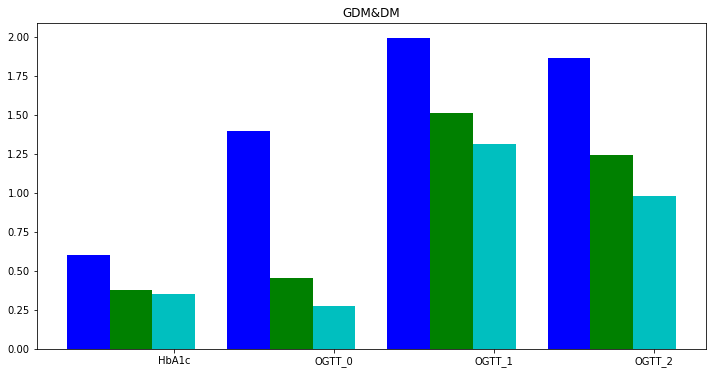

In [47]:
print("                         不同健康人群的患GDM&DM情况 \n")
plt.figure(figsize=(12,6))  # 设置图表大小

names = ["HbA1c","OGTT_0","OGTT_1","OGTT_2"]
x = [0,1,2,3]
total_width, n = 0.8, 3
width = total_width / n
a=plt.bar(x, stat_STATUS.iloc[0,], width=width,fc = 'blue')  
for i in range(len(x)):  
    x[i] = x[i] + width 
b=plt.bar(x,stat_STATUS.iloc[1,], width=width,fc = 'g') 
for i in range(len(x)):  
    x[i] = x[i] + width 
c=plt.bar(x,stat_STATUS.iloc[2,], width=width,tick_label = names,fc = 'c') 

plt.title(u'GDM&DM')


<b> 2) 饼图 </b>

准备数据

作图

                               各年龄段患DM（糖尿病）情况


<Figure size 1440x1440 with 0 Axes>

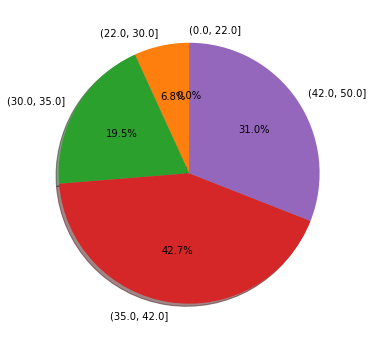

In [45]:
plt.figure(figsize=(20,20))
stat_age_range = pd.DataFrame(stat_age_range.to_records())
plt.figure(figsize=(6,6))
test=stat_age_range.filter(items=["age_range","DM%"])
plt.pie(x=test["DM%"],labels = test["age_range"],autopct="%3.1f%%",shadow=True,labeldistance=1.1,startangle=90,pctdistance=0.6)
print("                               各年龄段患DM（糖尿病）情况")
plt.show()